Nhập đường dẫn thư mục video: /content/drive/MyDrive/motions

KẾT QUẢ PHÂN CỤM
- Silhouette Score: 0.712
- Số cụm: 4


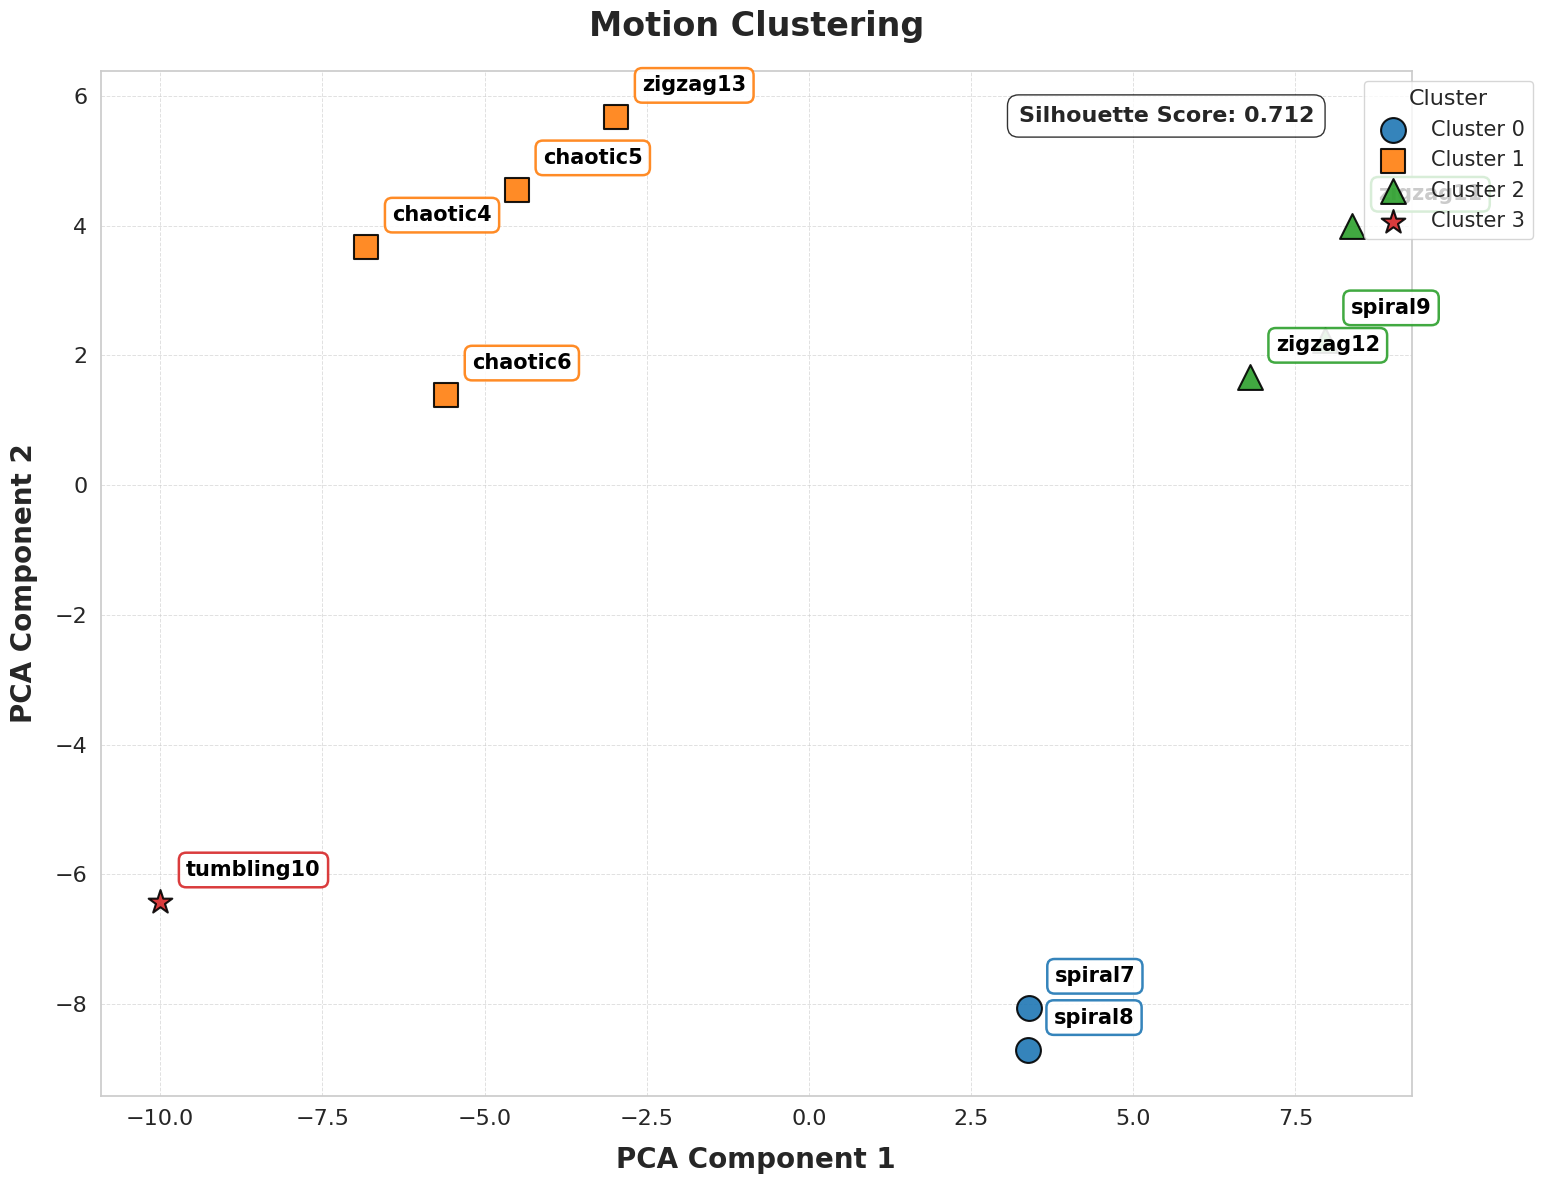

Cluster 0 (2 video):
  - spiral7.mp4
  - spiral8.mp4
Cluster 1 (4 video):
  - chaotic4.mp4
  - chaotic5.mp4
  - chaotic6.mp4
  - zigzag13.mp4
Cluster 2 (3 video):
  - spiral9.mp4
  - zigzag11.mp4
  - zigzag12.mp4
Cluster 3 (1 video):
  - tumbling10.mp4


In [ ]:
"""
TRÍCH XUẤT ĐẶC TRƯNG VẬT LÝ VÀ PHÂN CỤM CHUYỂN ĐỘNG
----------------------------------------------------
Code này thực hiện:
1. Trích xuất đặc trưng vật lý từ video chuyển động
2. Phân cụm bằng Autoencoder và KMeans
"""

# STEP 0: Import thư viện cần thiết
import os
import logging
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks

# Thư viện sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Thư viện PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Cấu hình logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Hằng số
THRESHOLD_VALUE = 200  # Ngưỡng nhị phân hóa ảnh
MIN_CONTOUR_AREA = 50  # Diện tích contour tối thiểu (pixel)
MIN_FRAMES = 3  # Số frame tối thiểu để phân tích
NU_AIR = 1.5e-5  # Hệ số nhớt không khí (m²/s)
PIXEL_TO_METER = 0.001  # Tỉ lệ pixel sang mét


# STEP 1: Trích xuất đặc trưng từ video
def extract_physical_quantities(video_path):
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Không thể mở video: {video_path}")

        fps = cap.get(cv2.CAP_PROP_FPS)
        if fps <= 0:
            logging.warning(f"FPS không hợp lệ ({fps}) trong video {video_path}")
            return None

        trajectory = []
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)

            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest = max(contours, key=cv2.contourArea)
                if cv2.contourArea(largest) >= MIN_CONTOUR_AREA:
                    M = cv2.moments(largest)
                    if M["m00"] != 0:
                        cx = int(M["m10"] / M["m00"])
                        cy = int(M["m01"] / M["m00"])
                        trajectory.append((cx, cy, frame_count))

            frame_count += 1

        cap.release()

        trajectory = np.array(trajectory)
        if len(trajectory) < MIN_FRAMES:
            logging.warning(f"Quá ít điểm trong video: {os.path.basename(video_path)}")
            return None

        coords = trajectory[:, :2]
        times = trajectory[:, 2] / fps

        velocities = []
        for i in range(len(times) - 1):
            time_diff = times[i + 1] - times[i]
            if time_diff > 0:
                velocities.append(euclidean(coords[i + 1], coords[i]) / time_diff)

        velocities = np.array(velocities)
        mean_speed = np.mean(velocities) if len(velocities) > 0 else 0

        def dominant_frequency(signal):
            signal = signal - np.mean(signal)
            if len(signal) < 4:
                return 0
            fft = np.fft.fft(signal)
            freq = np.fft.fftfreq(len(signal))
            power = np.abs(fft)
            pos_mask = freq > 0
            return freq[pos_mask][np.argmax(power[pos_mask])] if np.any(pos_mask) else 0

        dominant_freq_x = dominant_frequency(coords[:, 0])

        return {
            "mean_speed": np.nan_to_num(mean_speed),
            "dominant_freq_x": np.nan_to_num(dominant_freq_x),
            "video_name": os.path.basename(video_path)
        }

    except Exception as e:
        logging.error(f"Lỗi khi xử lý video {video_path}: {str(e)}")
        return None


# STEP 2: Xử lý toàn bộ thư mục video
def process_video_folder(folder_path):
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder không tồn tại: {folder_path}")

    video_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".mp4", ".avi", ".mov"))
    ]

    if not video_files:
        logging.warning(f"Không tìm thấy video trong {folder_path}")
        return None

    results = []
    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        features = extract_physical_quantities(video_path)
        if features:
            results.append(features)

    return pd.DataFrame(results) if results else None



# STEP 3: Tiền xử lý dữ liệu
from sklearn.preprocessing import PowerTransformer

def preprocess_data(df):
    if df is None or df.empty:
        raise ValueError("DataFrame is empty or invalid.")

    selected_features = [ 'mean_speed', 'dominant_freq_x']

    scaler = PowerTransformer()
    X_scaled = scaler.fit_transform(df[selected_features])

    return X_scaled, selected_features



# STEP 4: Mô hình Autoencoder
class MotionAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train_autoencoder(X_scaled, epochs=100):
    """Huấn luyện autoencoder"""
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = MotionAutoencoder(input_dim=X_scaled.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in loader:
            optimizer.zero_grad()
            outputs = model(batch[0])
            loss = criterion(outputs, batch[0])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        losses.append(avg_loss)
        if (epoch+1) % 20 == 0:
            logging.info(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model, losses



# STEP 5: Phân cụm và đánh giá
def cluster_and_evaluate(model, X_scaled, df, expected_clusters=4):
    """Phân cụm và trực quan hóa kết quả nếu đủ cluster"""

    with torch.no_grad():
        latent = model.encoder(torch.tensor(X_scaled, dtype=torch.float32)).numpy()

    # Phân cụm KMeans
    kmeans = KMeans(n_clusters=expected_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(latent)
    df['cluster'] = clusters

    unique_clusters = np.unique(clusters)
    num_clusters_found = len(unique_clusters)

    print("\nKẾT QUẢ PHÂN CỤM")

    if num_clusters_found == 1:
        print("- Tất cả dữ liệu thuộc 1 cụm duy nhất.")
        return df
    elif num_clusters_found < expected_clusters:
        print(f"- Phát hiện {num_clusters_found} cụm, thấp hơn số cụm mong muốn {expected_clusters}.")
        print("⚠️ Không vẽ biểu đồ.")
        return df
    else:
        # Silhouette Score
        score = silhouette_score(latent, clusters)
        print(f"- Silhouette Score: {score:.3f}")
        print(f"- Số cụm: {num_clusters_found}")

        # Giảm chiều dữ liệu bằng PCA
        pca = PCA(n_components=2)
        latent_2d = pca.fit_transform(latent)

        max_abs = np.max(np.abs(latent_2d))
        if max_abs > 0:
            latent_2d = latent_2d / max_abs * 10

        plt.figure(figsize=(16, 12))
        ax = plt.gca()

        # Định nghĩa các marker khác nhau cho mỗi cụm
        markers = ['o', 's', '^', '*', 'D', 'P', 'X', 'v']
        colors = plt.cm.tab10.colors

        for cluster_id in unique_clusters:
            indices = df['cluster'] == cluster_id
            points = latent_2d[indices]
            marker = markers[cluster_id % len(markers)]
            color = colors[cluster_id % len(colors)]

            # Vẽ điểm cluster
            plt.scatter(
                points[:, 0], points[:, 1],
                s=320,  # Kích thước marker lớn
                c=[color],
                marker=marker,
                edgecolors='black',
                linewidths=1.5,
                label=f"Cluster {cluster_id}",
                alpha=0.9
            )

            # Ghi tên video với box viền màu cụm
            for i, (x, y) in enumerate(points):
                video_idx = df[indices].index[i]
                name = os.path.splitext(df.iloc[video_idx]["video_name"])[0]
                ax.text(x + 0.4, y + 0.4, name,
                        fontsize=15,
                        fontweight='bold',
                        color='black',
                        bbox=dict(facecolor='white', edgecolor=color,
                                  boxstyle='round,pad=0.35', linewidth=1.8, alpha=0.9))

        # Hiển thị silhouette score
        plt.text(0.70, 0.95,
                 f'Silhouette Score: {score:.3f}',
                 transform=ax.transAxes,
                 fontsize=16,
                 fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5'))

        # Cài đặt trục và font chữ
        ax.set_aspect('equal', adjustable='box')
        plt.title("Motion Clustering", fontsize=24, fontweight='bold', pad=25)
        plt.xlabel("PCA Component 1", fontsize=20, fontweight='bold', labelpad=12)
        plt.ylabel("PCA Component 2", fontsize=20, fontweight='bold', labelpad=12)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        # Hiển thị legend
        plt.legend(title='Cluster', title_fontsize=16, fontsize=15,
                   loc='upper right', bbox_to_anchor=(1.10, 1))

        plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

        try:
            plt.tight_layout()
        except Exception:
            pass

        plt.show()

    # In danh sách video theo cụm
    for c in unique_clusters:
        videos_in_cluster = df[df['cluster'] == c]['video_name'].tolist()
        print(f"Cluster {c} ({len(videos_in_cluster)} video):")
        for v in videos_in_cluster:
            print(f"  - {v}")

    return df







# HÀM MAIN
def main():
    try:
        folder_path = input("Nhập đường dẫn thư mục video: ").strip()

        logging.info("Bắt đầu trích xuất đặc trưng...")
        df = process_video_folder(folder_path)
        if df is None or df.empty:
            logging.error("Không có dữ liệu hợp lệ để xử lý")
            return

        logging.info("Chuẩn hóa dữ liệu...")
        X_scaled, _ = preprocess_data(df)

        logging.info("Huấn luyện Autoencoder...")
        model, losses = train_autoencoder(X_scaled)

        logging.info("Phân cụm dữ liệu...")
        df = cluster_and_evaluate(model, X_scaled, df)

        output_dir = "results"
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "motion_clusters.csv")
        df.to_csv(output_path, index=False)
        logging.info(f"Đã lưu kết quả tại: {output_path}")

    except Exception as e:
        logging.error(f"Lỗi trong quá trình xử lý: {str(e)}")

if __name__ == "__main__":
    main()